In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import numpy as np
import networkx as nx


# Parameters
num_nodes = 1000
hidden_channels = 16

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Generate synthetic graph
G = nx.barabasi_albert_graph(num_nodes, 5)

# Set random seed
np.random.seed(42)

# Generate alignment scores between -1 and 1
node_features = np.random.uniform(range(0, 1), size=(num_nodes, 1))

# Assign labels based on alignment scores
labels = (node_features[:, 0] >= .5).astype(float)

# Add features and labels to the graph
for idx, node_id in enumerate(G.nodes()):
    G.nodes[node_id]['x'] = node_features[idx]
    G.nodes[node_id]['y'] = labels[idx]

# Convert to PyG data object
data = from_networkx(G)
data.x = torch.tensor(np.array([data.x[i] for i in range(num_nodes)]), dtype=torch.float)
data.y = torch.tensor(np.array([data.y[i] for i in range(num_nodes)]), dtype=torch.long)

# Define party positions
party_positions = {
    0: 0.25,  # Party A
    1: 0.75   # Party B
}

# Create masks
torch.manual_seed(42)
num_training = int(num_nodes * 0.8)
num_validation = int(num_nodes * 0.1)
indices = np.random.permutation(num_nodes)
train_indices = indices[:num_training]
val_indices = indices[num_training:num_training + num_validation]
test_indices = indices[num_training + num_validation:]

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

# Define the model
class ElectionGCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(ElectionGCN, self).__init__()
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = ElectionGCN(hidden_channels)

Using device: cuda


C:\Users\zacha\DataspellProjects\dsProject\venv\Lib\site-packages\torch_geometric\utils\convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  data_dict[key] = torch.as_tensor(value)


In [2]:
print(data.y)

tensor([1, 0, 3, 2, 1, 1, 0, 3, 2, 3, 0, 0, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1,
        2, 3, 1, 2, 2, 0, 2, 1, 0, 0, 0, 3, 1, 0, 3, 2, 0, 2, 0, 0, 1, 3, 1, 2,
        2, 1, 0, 3, 0, 0, 2, 0, 0, 1, 0, 1, 2, 1, 3, 1, 1, 2, 1, 3, 0, 0, 3, 1,
        0, 3, 3, 3, 3, 0, 1, 0, 3, 2, 1, 0, 1, 1, 3, 3, 0, 2, 0, 3, 3, 2, 3, 2,
        2, 2, 0, 0, 0, 3, 1, 2, 0, 1, 2, 3, 1, 0, 1, 1, 0, 3, 3, 3, 3, 1, 0, 2,
        3, 0, 1, 0, 1, 2, 3, 3, 0, 2, 2, 1, 0, 1, 0, 1, 2, 3, 1, 0, 0, 1, 2, 1,
        1, 0, 2, 2, 0, 1, 0, 1, 1, 2, 0, 1, 3, 3, 1, 3, 1, 3, 3, 2, 0, 3, 1, 1,
        0, 2, 3, 0, 2, 1, 3, 1, 3, 2, 0, 1, 1, 0, 0, 0, 1, 3, 3, 2, 2, 1, 0, 0,
        0, 3, 1, 1, 3, 0, 0, 3, 3, 0, 1, 0, 2, 0, 0, 3, 0, 1, 2, 3, 3, 1, 3, 1,
        1, 3, 3, 3, 3, 2, 0, 1, 1, 1, 0, 2, 0, 3, 3, 2, 2, 2, 1, 3, 1, 0, 3, 1,
        0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 1, 2, 3, 1, 1, 2, 0, 3, 2, 0, 2, 0, 1, 2,
        0, 3, 3, 3, 1, 1, 3, 3, 3, 0, 2, 2, 3, 3, 3, 3, 0, 1, 2, 0, 2, 0, 2, 2,
        1, 2, 0, 0, 3, 1, 1, 2, 3, 1, 2,

In [3]:
# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
criterion = nn.NLLLoss()

# Training and evaluation functions
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index).squeeze()
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    accuracy = int(correct.sum()) / int(mask.sum())
    return accuracy

# Training loop
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc = evaluate(data.train_mask)
        val_acc = evaluate(data.val_mask)
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

# Test evaluation
test_acc = evaluate(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

# Use the model for simulation
model.eval()
out = model(data.x, data.edge_index)
probabilities = torch.exp(out)
predictions = probabilities.argmax(dim=1)
print(predictions)

IndexError: Target 2 is out of bounds.

In [27]:
print(data.x)

tensor([[0.3745],
        [0.9507],
        [0.7320],
        [0.5987],
        [0.1560],
        [0.1560],
        [0.0581],
        [0.8662],
        [0.6011],
        [0.7081],
        [0.0206],
        [0.9699],
        [0.8324],
        [0.2123],
        [0.1818],
        [0.1834],
        [0.3042],
        [0.5248],
        [0.4319],
        [0.2912],
        [0.6119],
        [0.1395],
        [0.2921],
        [0.3664],
        [0.4561],
        [0.7852],
        [0.1997],
        [0.5142],
        [0.5924],
        [0.0465],
        [0.6075],
        [0.1705],
        [0.0651],
        [0.9489],
        [0.9656],
        [0.8084],
        [0.3046],
        [0.0977],
        [0.6842],
        [0.4402],
        [0.1220],
        [0.4952],
        [0.0344],
        [0.9093],
        [0.2588],
        [0.6625],
        [0.3117],
        [0.5201],
        [0.5467],
        [0.1849],
        [0.9696],
        [0.7751],
        [0.9395],
        [0.8948],
        [0.5979],
        [0

In [18]:
num_ones = torch.sum(predictions == 1).item()
num_zeros = torch.sum(predictions == 0).item()

print(f'Number of 1s: {num_ones}')
print(f'Number of 0s: {num_zeros}')

Number of 1s: 550
Number of 0s: 450


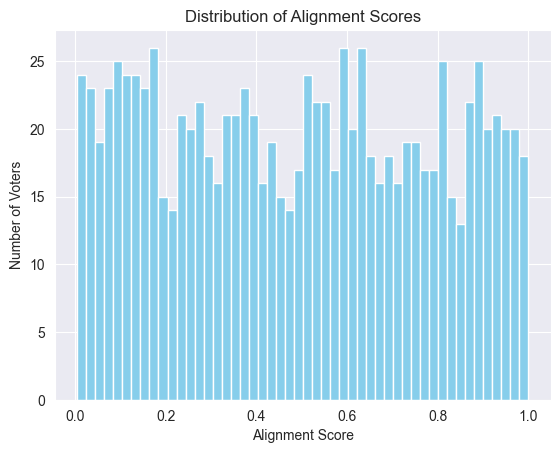

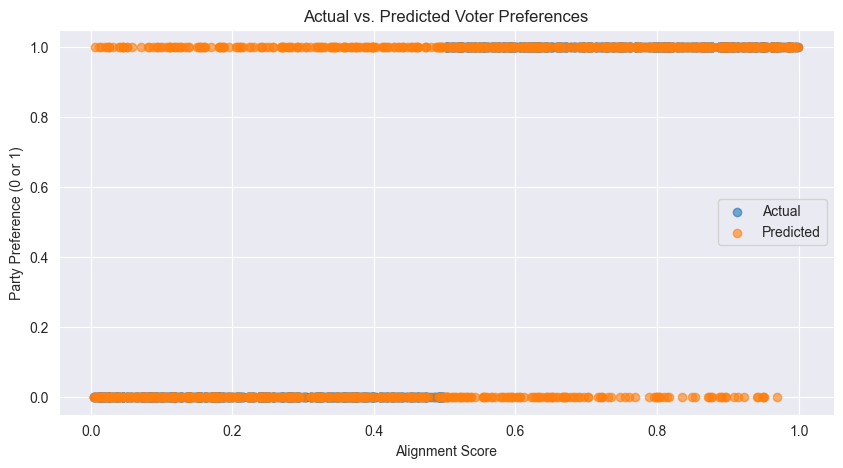

In [19]:
import matplotlib.pyplot as plt

# Plot alignment scores histogram
plt.hist(node_features, bins=50, color='skyblue')
plt.title('Distribution of Alignment Scores')
plt.xlabel('Alignment Score')
plt.ylabel('Number of Voters')
plt.show()

# Plot actual vs. predicted preferences
plt.figure(figsize=(10, 5))
plt.scatter(node_features, labels, label='Actual', alpha=0.6)
plt.scatter(node_features, predictions.detach().numpy(), label='Predicted', alpha=0.6)
plt.title('Actual vs. Predicted Voter Preferences')
plt.xlabel('Alignment Score')
plt.ylabel('Party Preference (0 or 1)')
plt.legend()
plt.show()

In [20]:
import math
# Use the model for simulation
model.eval()
with torch.no_grad():
    updated_alignment_scores = model(data.x, data.edge_index).cpu().numpy().flatten()

# Assign preferred parties based on closest party position
preferred_parties = []
for score in updated_alignment_scores:
    distances = {party: abs(math.log(pos - score)) for party, pos in party_positions.items()}
    preferred_party = min(distances, key=distances.get)
    preferred_parties.append(preferred_party)
    print(f'Alignment Score: {score:.4f}, Preferred Party: {preferred_party}')

Alignment Score: -0.7984, Preferred Party: 0
Alignment Score: -0.5979, Preferred Party: 0
Alignment Score: -1.1871, Preferred Party: 0
Alignment Score: -0.3640, Preferred Party: 1
Alignment Score: -3.2884, Preferred Party: 0
Alignment Score: -0.0380, Preferred Party: 1
Alignment Score: -1.6291, Preferred Party: 0
Alignment Score: -0.2183, Preferred Party: 1
Alignment Score: -1.1428, Preferred Party: 0
Alignment Score: -0.3841, Preferred Party: 1
Alignment Score: -1.4708, Preferred Party: 0
Alignment Score: -0.2610, Preferred Party: 1
Alignment Score: -0.8099, Preferred Party: 0
Alignment Score: -0.5886, Preferred Party: 0
Alignment Score: -1.4475, Preferred Party: 0
Alignment Score: -0.2681, Preferred Party: 1
Alignment Score: -0.3321, Preferred Party: 1
Alignment Score: -1.2638, Preferred Party: 0
Alignment Score: -1.5027, Preferred Party: 0
Alignment Score: -0.2517, Preferred Party: 1
Alignment Score: -0.7455, Preferred Party: 0
Alignment Score: -0.6434, Preferred Party: 0
Alignment 

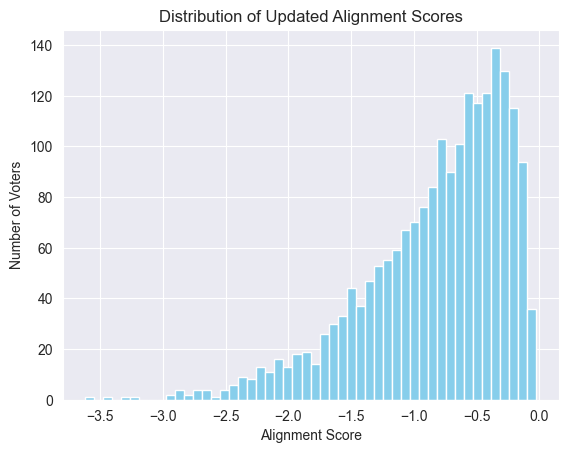

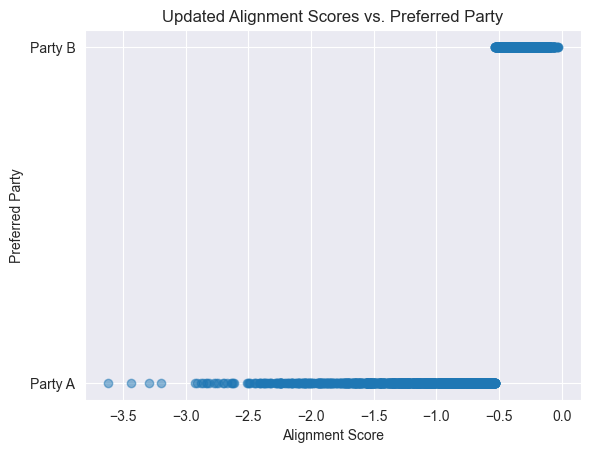

In [21]:
import matplotlib.pyplot as plt

# Plot the distribution of updated alignment scores
plt.hist(updated_alignment_scores, bins=50, color='skyblue')
plt.title('Distribution of Updated Alignment Scores')
plt.xlabel('Alignment Score')
plt.ylabel('Number of Voters')
plt.show()

# Scatter plot of alignment scores vs. preferred party
plt.scatter(updated_alignment_scores, preferred_parties, alpha=0.5)
plt.title('Updated Alignment Scores vs. Preferred Party')
plt.xlabel('Alignment Score')
plt.ylabel('Preferred Party')
plt.yticks([0, 1], ['Party A', 'Party B'])
plt.show()


In [7]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import numpy as np
import networkx as nx


# Parameters
num_nodes = 1000
hidden_channels = 16

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Generate synthetic graph
G = nx.barabasi_albert_graph(num_nodes, 5)

# Set random seed
np.random.seed(42)

# Generate alignment scores between 0 and 4
node_features = np.random.uniform(0, 4, size=(num_nodes, 1))

# Assign labels based on alignment scores
labels = np.zeros(num_nodes, dtype=int)
labels[(node_features[:, 0] >= 0.5) & (node_features[:, 0] < 1.5)] = 1
labels[(node_features[:, 0] >= 1.5) & (node_features[:, 0] < 2.5)] = 2
labels[(node_features[:, 0] >= 2.5) & (node_features[:, 0] < 3.5)] = 3
labels[(node_features[:, 0] >= 3.5) & (node_features[:, 0] < 4.0)] = 0

# Add features and labels to the graph
for idx, node_id in enumerate(G.nodes()):
    G.nodes[node_id]['x'] = node_features[idx]
    G.nodes[node_id]['y'] = labels[idx]

# Convert to PyG data object
data = from_networkx(G)
data.x = torch.tensor(np.array([data.x[i] for i in range(num_nodes)]), dtype=torch.float)
data.y = torch.tensor(np.array([data.y[i] for i in range(num_nodes)]), dtype=torch.long)

# Create masks
torch.manual_seed(42)
num_training = int(num_nodes * 0.8)
num_validation = int(num_nodes * 0.1)
indices = np.random.permutation(num_nodes)
train_indices = indices[:num_training]
val_indices = indices[num_training:num_training + num_validation]
test_indices = indices[num_training + num_validation:]

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

# Define the model
class ElectionGCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(ElectionGCN, self).__init__()
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = ElectionGCN(hidden_channels)

Using device: cuda


In [11]:
# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
criterion = nn.NLLLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    accuracy = int(correct.sum()) / int(mask.sum())
    return accuracy

# Training loop
for epoch in range(1, 301):
    loss = train()
    if epoch % 10 == 0:
        train_acc = evaluate(data.train_mask)
        val_acc = evaluate(data.val_mask)
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

# Test evaluation
test_acc = evaluate(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

# Use the model for simulation
model.eval()
out = model(data.x, data.edge_index)
probabilities = torch.exp(out)
predictions = probabilities.argmax(dim=1)
print(predictions)

Epoch 10, Loss: 1.3236, Train Acc: 0.2787, Val Acc: 0.3900
Epoch 20, Loss: 1.3328, Train Acc: 0.2888, Val Acc: 0.4100
Epoch 30, Loss: 1.3287, Train Acc: 0.2913, Val Acc: 0.4000
Epoch 40, Loss: 1.3260, Train Acc: 0.2875, Val Acc: 0.3900
Epoch 50, Loss: 1.3299, Train Acc: 0.2888, Val Acc: 0.3900
Epoch 60, Loss: 1.3219, Train Acc: 0.2812, Val Acc: 0.3900
Epoch 70, Loss: 1.3261, Train Acc: 0.2925, Val Acc: 0.4000
Epoch 80, Loss: 1.3254, Train Acc: 0.2938, Val Acc: 0.4000
Epoch 90, Loss: 1.3220, Train Acc: 0.2888, Val Acc: 0.3600
Epoch 100, Loss: 1.3246, Train Acc: 0.3000, Val Acc: 0.3700
Epoch 110, Loss: 1.3221, Train Acc: 0.2863, Val Acc: 0.3800
Epoch 120, Loss: 1.3287, Train Acc: 0.2875, Val Acc: 0.3700
Epoch 130, Loss: 1.3230, Train Acc: 0.2913, Val Acc: 0.3800
Epoch 140, Loss: 1.3245, Train Acc: 0.2900, Val Acc: 0.3900
Epoch 150, Loss: 1.3232, Train Acc: 0.2950, Val Acc: 0.3800
Epoch 160, Loss: 1.3298, Train Acc: 0.2900, Val Acc: 0.3800
Epoch 170, Loss: 1.3246, Train Acc: 0.3025, Val A

In [12]:
num_ones = torch.sum(predictions == 1).item()
num_zeros = torch.sum(predictions == 0).item()
num_twos = torch.sum(predictions == 2).item()
num_threes = torch.sum(predictions == 3).item()

print(f'Number of 0s: {num_zeros}')
print(f'Number of 1s: {num_ones}')
print(f'Number of 2s: {num_twos}')
print(f'Number of 3s: {num_threes}')

Number of 0s: 363
Number of 1s: 224
Number of 2s: 136
Number of 3s: 277
